In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation

In [111]:
# Field names for your CSV file - query, docid, rating, rater.  Change these to match your csv headers
field_query = 'topicID'
field_docid = 'docID'
field_gold = 'gold'
field_rating = 'label'
field_rater = 'workerID'

raw_csv_filename = 'trec-20002.csv'
obfuscated_csv_filename = 'trec-20002-obfuscated.csv'
def obfuscate_raters(judgements):
    #Drop NaN ratings and sort by the rater
    groups = judgements.dropna(subset=[field_rating])
    groups = groups.sort_values(by=[field_rater])
    #Obfuscate rater into a letter (for example john.smith@example.com ==> 'A')
    #WARNING, this uses ASCII to iterate and looks strange if you have more than 26 raters!!!!
    last = None
    rater_index = 65
    for index, row in groups.iterrows():
        if last is not None:
            if last[field_rater]!=row[field_rater]:
                rater_index+=1
        last = row
        groups.at[index,field_rater]=chr(rater_index)
    groups = groups.sort_index()
    return groups

def elo_initialize(judgements,noob=1000,hasNIST=True):
    ratings = {}
    if (hasNIST):
        ratings['NIST']=3000
    raters = sorted(judgements[field_rater].unique())
    for rater in raters:
        ratings[rater] = noob
    return ratings

def elo_expected(A, B):
    return 1 / (1 + 10 ** ((B - A) / 400))

def elo(whiteRating,blackRating,whiteResult,blackResult,kwhite=8,kblack=8):
    white = (whiteRating+(kwhite*(whiteResult-elo_expected(blackRating,whiteRating))))
    black = (blackRating+(kblack*(blackResult-elo_expected(whiteRating,blackRating))))
    return white,black

def elo_rate_raters(judgements,noob=1000,outliers=[]):
    gb = [field_query,field_docid,field_rating]
    for o in outliers:
        print(o)
        judgements = judgements[judgements[field_rater]!=o]
    print(judgements)
    counts = judgements.loc[:,gb].groupby(gb).size().reset_index(name='counts')
    counts = counts.iloc[counts.groupby([field_query,field_docid])['counts'].agg(pd.Series.idxmax)]
    counts = counts.sample(frac=1)
    print(counts)
    elo_ratings = elo_initialize(judgements,noob,hasNIST=False)
    frame_data = [elo_ratings.copy()]
    frame_num = 1
    for idx,row in counts.iterrows():
        if row['counts']>1:
            #field_query,field_docid,field_rating
            agree = judgements.loc[(judgements[field_query]==row[field_query]) & (judgements[field_docid]==row[field_docid]) & (judgements[field_rating]==row[field_rating])]
            disagree = judgements.loc[(judgements[field_query]==row[field_query]) & (judgements[field_docid]==row[field_docid]) & (judgements[field_rating]!=row[field_rating])]
            len_agree = len(agree[field_rater])
            len_disagree = len(disagree[field_rater])
            #print('------------')
            #print(row)
            #print(row['counts'])
            #print(agree)
            #print(disagree)
            #print(len_agree)
            #print(len_disagree)
            for aidx,arow in agree.iterrows():
                won = arow[field_rater]
                for didx,drow in disagree.iterrows():
                    current_ratings = frame_data[frame_num-1].copy()
                    lost = drow[field_rater]
                    ws,ls = elo(current_ratings[won],current_ratings[lost],1,0,kwhite=1.1,kblack=1.1)
                    current_ratings[won] = ws
                    current_ratings[lost] = ls
                    frame_data.append(current_ratings)
                    frame_num += 1
    print(len(frame_data))
    return frame_data

def elo_rate(ratings,gold,rating,rater):
    win_house = 1
    win_rater = 0
    if (gold==rating):
        win_house = 0
        win_rater = 1
    ws,bs = elo(ratings['NIST'],ratings[rater],win_house,win_rater)
    return ws,bs

def elo_rate_row(elo_ratings,idx,row):
    rater = row[field_rater]
    gold = row[field_gold]
    rating = row[field_rating]
    if (gold>-2 and rating>-2):
        ws,bs = elo_rate(elo_ratings,gold,rating,rater)
        #elo_ratings[w] = ws
        elo_ratings[rater] = bs
    return elo_ratings

def elo_rate_raters_vs_trec(judgements):
    elo_ratings = elo_initialize(judgements,noob=1000)
    frame_data = [elo_ratings.copy()]
    frame_num = 1
    for idx,row in judgements.iterrows():
        current_ratings = frame_data[frame_num-1].copy()
        frame_data.append(current_ratings)
        frame_data[frame_num] = elo_rate_row(current_ratings,idx,row)
        frame_num += 1
    print(len(frame_data))
    return frame_data

In [115]:
def animate_elo(frame_data,filename,page=10,dpi=None,width=None,height=None,xrotate=None):
    current_ratings = frame_data[len(frame_data)-1]
    fig = plt.figure(figsize=(8, 6),dpi=80)
    fig,ax = plt.subplots()
    if (dpi):
        fig.set_dpi(dpi)
    if (width and height):
        fig.set_figwidth(width, forward=True)
        fig.set_figheight(height, forward=True)
    rects = plt.bar(range(len(current_ratings)), list(current_ratings.values()), align='center')
    xticks = plt.xticks(range(len(current_ratings)), list(current_ratings.keys()), rotation=xrotate)
    patch = None

    frames = int(len(frame_data)/page)

    lims = ax.get_ylim()
    print(lims)
    
    def animate(i):
        for n in range(i*page,((i+1)*page)-1):
            if(n%1000==0):
                print(n)
            elo_ratings = frame_data[n]
            for rect, rater in zip(rects, elo_ratings):
                h = elo_ratings[rater]
                rect.set_height(h)
                if (h<0):
                    c = (h/lims[0])
                    rect.set_color((c, 1/9, 1/9, 1))
                else:
                    c = (h/lims[1])
                    rect.set_color((1/9, 1/9, c, 1))
        return rects


    #ani = animation.FuncAnimation(fig, animate, 10, interval=6, repeat=False, blit=True)
    ani = animation.FuncAnimation(fig, animate, frames, interval=3, repeat=False, blit=True)

    ani.save(filename, dpi=128)

    plt.show()

In [4]:
csv_data = pd.read_csv(raw_csv_filename,header=[0],encoding='utf-8')
judgement_data = obfuscate_raters(csv_data)

5824
(-11439.598057072442, 3687.59990747964)
0
0
0
1000
2000
3000
4000
5000


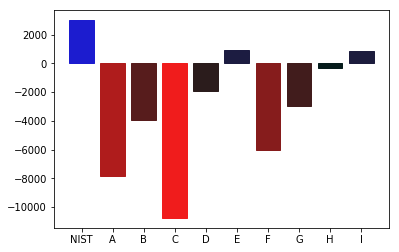

In [30]:
frame_data = elo_rate_raters_vs_trec(judgement_data)
animate_elo(frame_data,"movies/elo.mp4")

4145
(-8288.462213683631, 10283.004018681864)
0
0
0
1000
2000
3000
4000


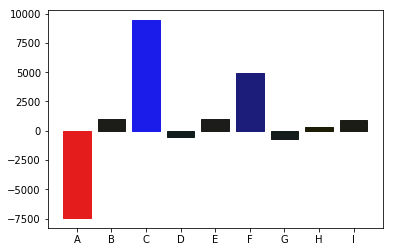

In [31]:
frame_data = elo_rate_raters(judgement_data)
animate_elo(frame_data,"movies/elo2.mp4")

In [38]:
all_csv_filename = 'trec-20002-top-108.csv'

In [40]:
all_csv_filename = 'trec-20002-top-108.csv'
csv_data = pd.read_csv(all_csv_filename,header=[0],encoding='utf-8')
min_outlier = 'w101'
max_outlier = 'w108'
frame_data_2=elo_rate_raters(csv_data,outliers=[min_outlier,max_outlier])

In [45]:
workers = csv_data.workerID.unique()

29864
(-56967.597892917816, 5855.599899662753)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


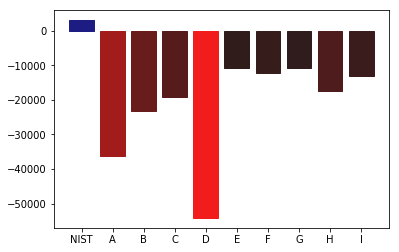

23626
(-38218.798102144814, 4962.799909625944)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000


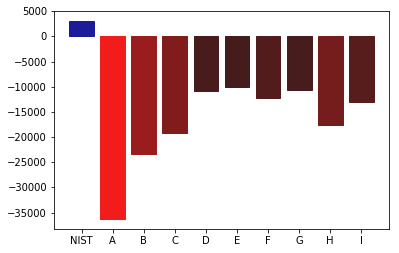

20037
(-24602.39771487789, 4314.399891184661)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


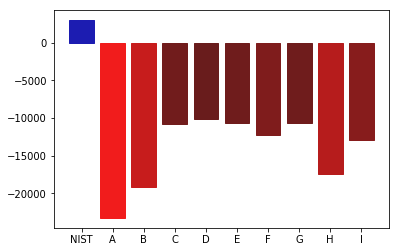

18180
(-20293.197878692332, 4109.199898985349)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


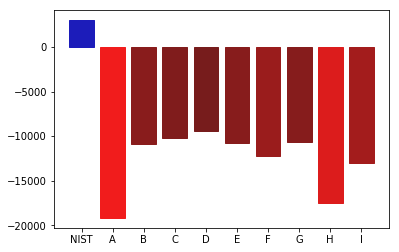

16783
(-18537.59796702957, 4025.5999031918846)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


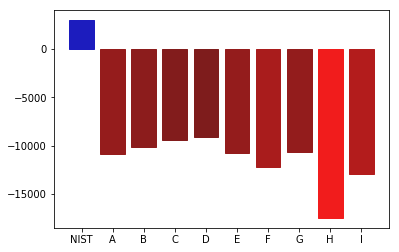

15395
(-13783.197981541452, 3799.1999038829263)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000


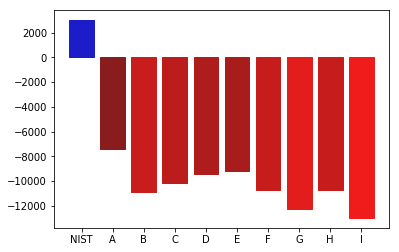

14479
(-13035.597791507349, 3763.5998948336833)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


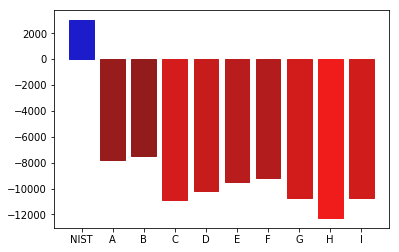

13697
(-11557.197835375147, 3693.199896922626)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


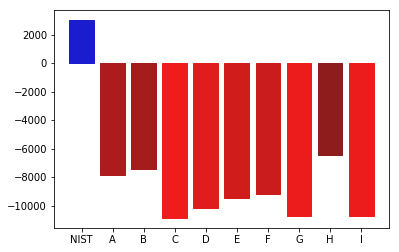

13030
(-11439.598065080654, 3687.5999078609834)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


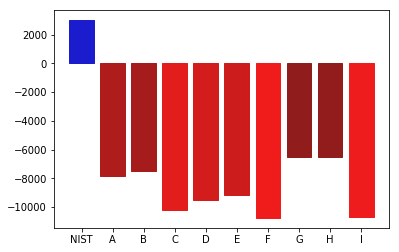

12445
(-11439.598065080654, 3687.5999078609834)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


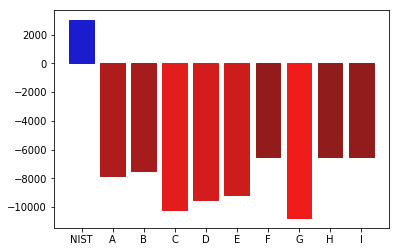

11800
(-11439.598065080654, 3687.5999078609834)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


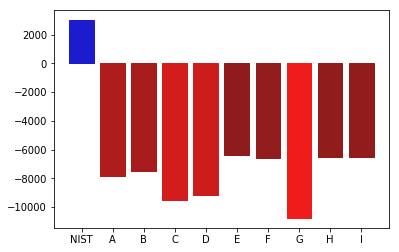

11169
(-10095.597583296492, 3623.599884918881)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


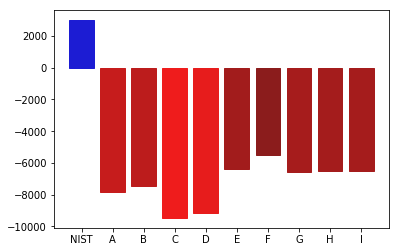

In [57]:
for i in range(0,12):
    group = workers[i:i+9]
    judgement_data = obfuscate_raters(csv_data[csv_data['workerID'].isin(group)])
    frame_data = elo_rate_raters_vs_trec(judgement_data)
    animate_elo(frame_data,"movies/elo_group_"+str(i)+".mp4")

6891
(-12958.045009021484, 10811.739643176703)
0
0
0
1000
2000
3000
4000
5000
6000


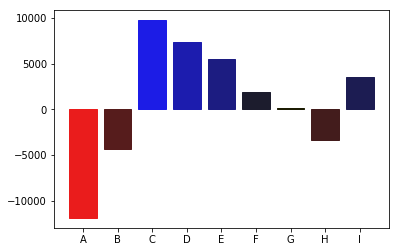

4148
(-6189.213473942319, 5679.817750761279)
0
0
0
1000
2000
3000
4000


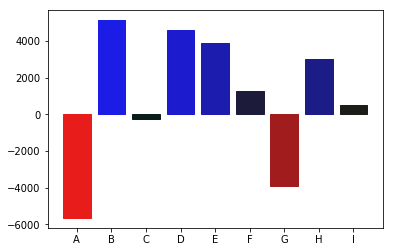

2578
(-4453.066808241737, 6210.724449104203)
0
0
0
1000
2000


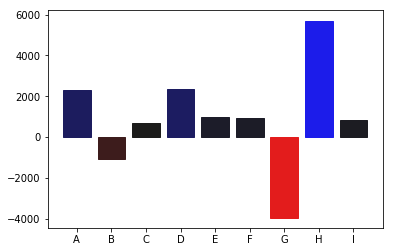

2377
(-4121.956288456583, 5494.710594052494)
0
0
0
1000
2000


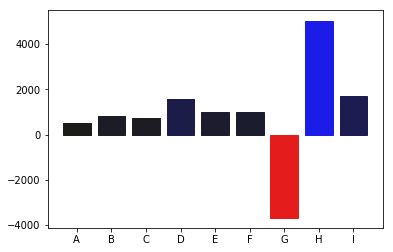

4084
(-9243.463872730897, 8958.467142590016)
0
0
0
1000
2000
3000
4000


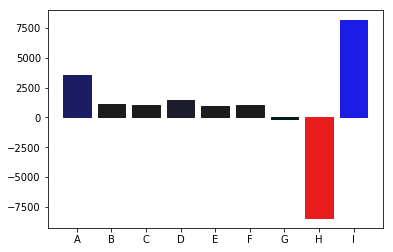

1431
(-1776.4040824779022, 3611.2270237261882)
0
0
0
1000


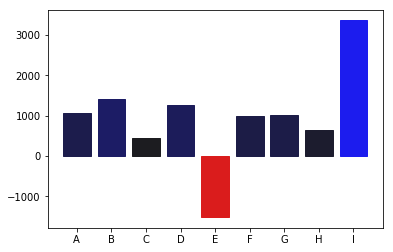

558
(-271.75391138626736, 1830.6681928800435)
0
0
0


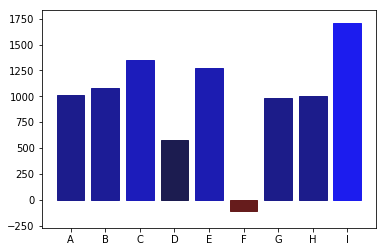

543
(-260.8050329696422, 1845.8970529278395)
0
0
0


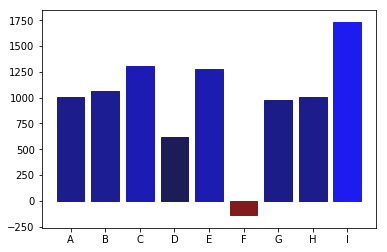

460
(0.0, 1457.184502840705)
0
0
0


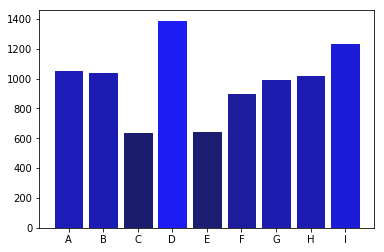

398
(0.0, 1550.3396325094384)
0
0
0


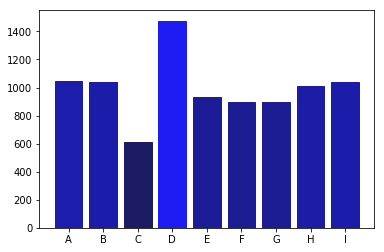

339
(0.0, 1487.0331022170235)
0
0
0


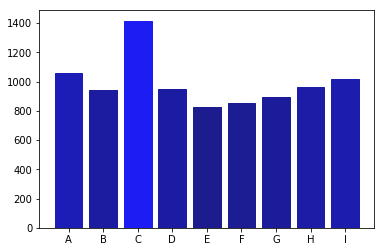

454
(0.0, 1679.4125547395201)
0
0
0


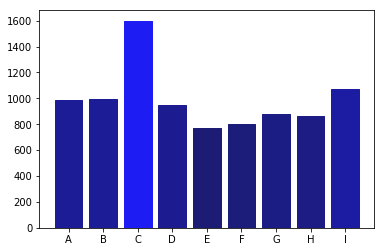

In [58]:
for i in range(0,12):
    group = workers[i:i+9]
    judgement_data = obfuscate_raters(csv_data[csv_data['workerID'].isin(group)])
    frame_data = elo_rate_raters(judgement_data)
    animate_elo(frame_data,"movies/elo_group_majoritywins_"+str(i)+".mp4")

46240
118280
(-9148.006457917338, 15324.870056834001)
0
0
0
1000
2000
3000
4000


KeyboardInterrupt: 

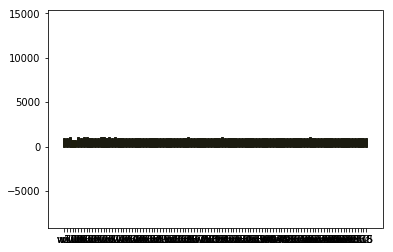

In [66]:
frame_data = elo_rate_raters(csv_data.sample(frac=1))
animate_elo(frame_data,"movies/elo_all.mp4")

In [96]:
frame_data = elo_rate_raters(csv_data)

       topicID                      docID  label  counts
3391     20018  clueweb09-en0032-58-00225      0       2
12697    20152  clueweb09-en0007-36-32138      0       2
23767    20330  clueweb09-en0048-20-07327     -2       1
2923     20016  clueweb09-en0008-83-28350      1       4
37528    20766  clueweb09-en0002-78-09252      1       2
45332    20986  clueweb09-en0003-92-21518      0       3
28481    20424  clueweb09-en0001-52-08821      1       3
42368    20956  clueweb09-en0009-33-17242     -2       2
45221    20986  clueweb09-en0000-27-06774      2       2
3314     20018  clueweb09-en0009-35-21245      0       1
5982     20032  clueweb09-en0007-90-35038      1       3
37557    20766  clueweb09-en0002-78-09316      0       2
29046    20440  clueweb09-en0004-72-10084      1       2
38582    20780  clueweb09-en0009-29-07770      0       2
18727    20228  clueweb09-en0011-72-35812      0       3
2200     20012  clueweb09-en0007-39-24332      1       2
30671    20480  clueweb09-enwp0

(-8748.382868790355, 10476.59539506575)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000


<Figure size 640x480 with 0 Axes>

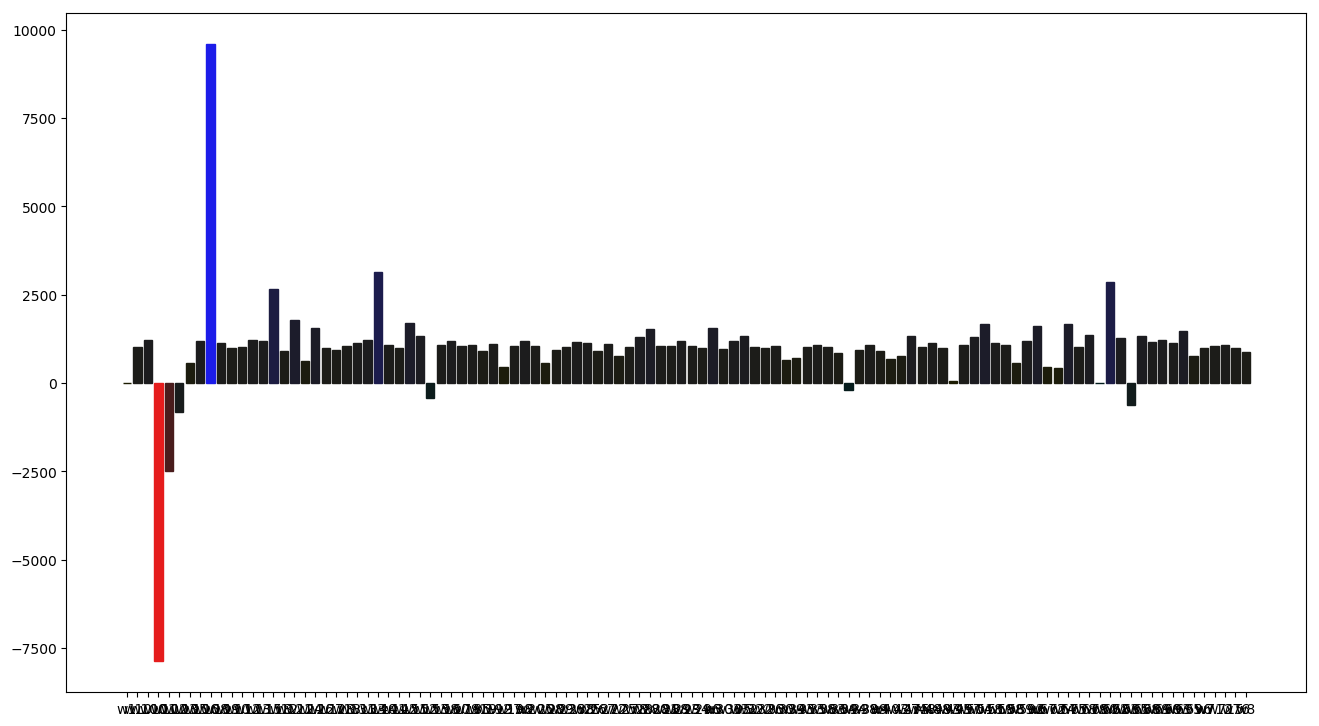

In [97]:
animate_elo(frame_data,"movies/elo_all.mp4",page=100,dpi=100,width=16,height=9)

In [98]:
frame_data[len(frame_data)-2:len(frame_data)]

[{'w1': 0.25117082814790104,
  'w10': 1019.9112508913101,
  'w100': 1224.8056314136147,
  'w101': -7874.52022043326,
  'w102': -2495.3204619311637,
  'w103': -822.8250439357478,
  'w105': 562.5916457159753,
  'w106': 1180.0541742205774,
  'w108': 9602.732746708654,
  'w109': 1125.7644286021725,
  'w110': 1000.8403719585212,
  'w112': 1011.6052853894586,
  'w113': 1206.126959488749,
  'w115': 1195.2372013967529,
  'w118': 2659.6377322257845,
  'w12': 921.2919122832537,
  'w121': 1781.1669999182855,
  'w124': 624.7294761403302,
  'w126': 1561.6059146796372,
  'w127': 1005.9784193810565,
  'w128': 946.1090473874012,
  'w13': 1037.4003530311077,
  'w131': 1143.550025416975,
  'w133': 1217.6818516042479,
  'w140': 3156.9318683526903,
  'w141': 1071.7811198068912,
  'w142': 996.9800604603143,
  'w151': 1697.1044661754079,
  'w152': 1338.0043996157044,
  'w153': -423.3010872873701,
  'w158': 1079.4461448176999,
  'w160': 1177.303098818526,
  'w179': 1048.0707349674674,
  'w185': 1075.42768109

In [123]:
min_outlier = 'w101'
max_outlier = 'w108'
frame_data_2=elo_rate_raters(csv_data,outliers=[min_outlier,max_outlier],noob=1)

w101
w108
       topicID workerID                      docID  gold  label
13149    20102     w102  clueweb09-en0005-00-18923    -1      0
13150    20102     w102  clueweb09-en0005-54-13217    -1      0
13151    20102     w102  clueweb09-en0001-97-28653     1      0
13152    20102     w102  clueweb09-en0007-54-37985    -1      0
13153    20186     w102  clueweb09-en0010-99-18702    -1      0
13154    20186     w102  clueweb09-en0010-99-18716    -1      0
13155    20186     w102  clueweb09-en0010-99-18700    -1      0
13156    20186     w102  clueweb09-en0010-99-18712    -1      0
13157    20186     w102  clueweb09-en0000-62-20678     0      0
13158    20102     w102  clueweb09-en0004-12-26742     0      0
13159    20102     w102  clueweb09-en0004-60-13115    -1      0
13160    20102     w102  clueweb09-enwp00-42-02182     0      0
13161    20102     w102  clueweb09-en0004-42-00466    -1      0
13162    20102     w102  clueweb09-en0004-34-24405     1      0
13163    20186     w102  cluew

(-1905.967808657292, 2599.5856964224845)
0
0
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


<Figure size 640x480 with 0 Axes>

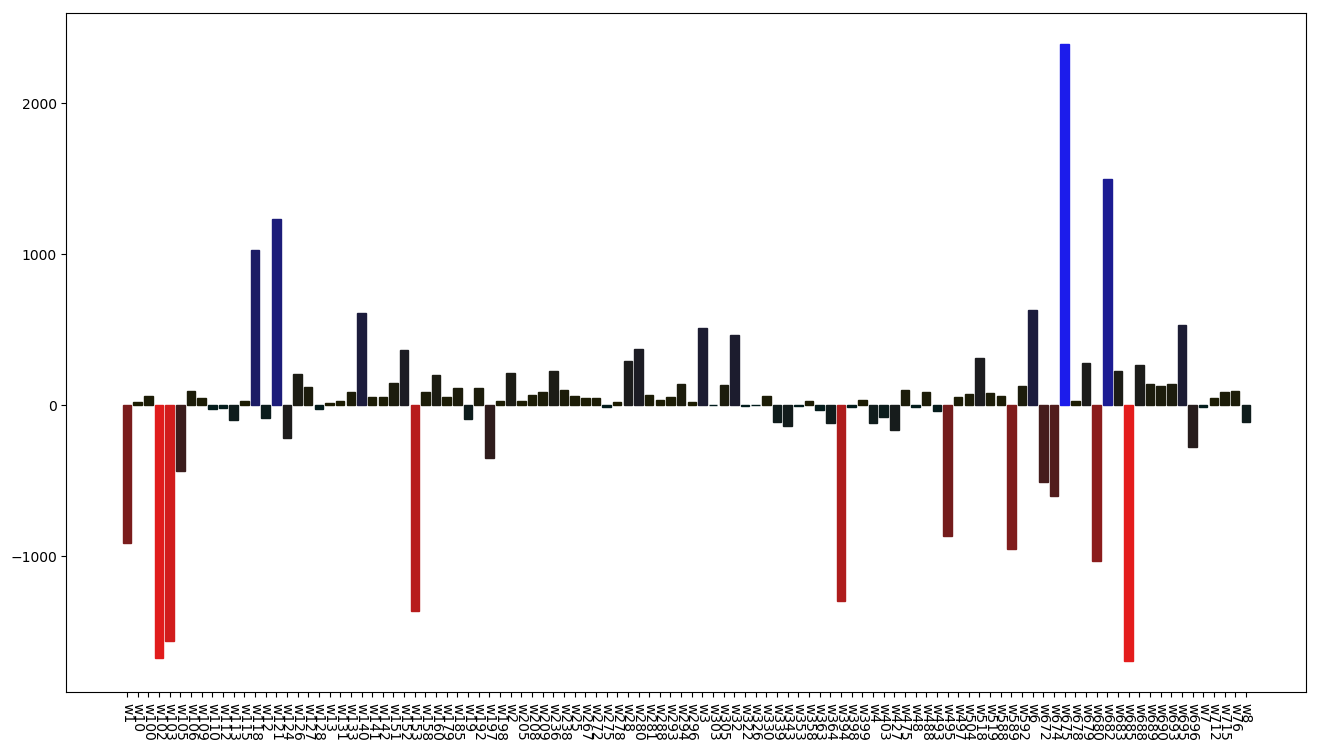

In [124]:
animate_elo(frame_data_2,"movies/elo_no_outliers_from_1.mp4",page=100,dpi=100,width=16,height=9,xrotate=-90)